### JOBarcelona ’22

In [5]:
#Importamos las librarias:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier #Import Decision Tree Classifier
from sklearn.linear_model import LogisticRegression #Import Logistic Regression Classifier
from sklearn.neighbors import KNeighborsClassifier #Import KNeighbors Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")


## Task 1: Análisis Exploratorio

In [6]:
#Importamos el dataset:
df_train= pd.read_csv('train.csv', index_col=0)
df_train.head()

Hour  Minutes  Sensor_alpha  Sensor_beta  Sensor_gamma  Sensor_alpha_plus  \
0    22       26    119.910995   242.838324   -316.819222         250.195048   
1    10       16    -90.790536  -269.470767   -182.581844          95.394941   
2    21       42    -20.028003  -147.070212     50.280872         -90.750386   
3    21       17    -21.258567     0.467070    -86.164153         -21.813529   
4    18       16    -58.154501   -13.051195   -156.501167          48.392938   

   Sensor_beta_plus  Sensor_gamma_plus  Insect  
0        -53.547777        -112.049983       2  
1         37.291944          48.525180       0  
2        -50.476556          85.399009       1  
3       -209.256006          16.291882       0  
4       -110.008860         -10.285138       2

In [7]:
#Algunas estadísticas de nuestro Data Set:
df_train.describe().round(2).T

count   mean     std     min     25%    50%    75%     max
Hour               7001.0  19.60    3.51    1.00   19.00  21.00  21.00   23.00
Minutes            7001.0  29.41   17.38    0.00   14.00  29.00  44.00   59.00
Sensor_alpha       7001.0   0.48   99.29 -404.90  -68.57  -0.29  66.48  351.26
Sensor_beta        7001.0 -29.97  133.10 -656.27 -116.06 -36.17  56.64  518.40
Sensor_gamma       7001.0  -5.62  115.87 -448.48  -83.51  -1.22  76.87  378.35
Sensor_alpha_plus  7001.0   7.19  122.33 -437.21  -79.50  -1.13  93.29  462.56
Sensor_beta_plus   7001.0  -0.76  100.04 -387.57  -68.06  -0.44  66.18  345.28
Sensor_gamma_plus  7001.0  -0.55  100.54 -374.96  -69.65   0.03  67.84  363.68
Insect             7001.0   0.60    0.66    0.00    0.00   0.00   1.00    2.00

In [8]:
#Información sobre cada columna:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7001 entries, 0 to 7000
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hour               7001 non-null   int64  
 1   Minutes            7001 non-null   int64  
 2   Sensor_alpha       7001 non-null   float64
 3   Sensor_beta        7001 non-null   float64
 4   Sensor_gamma       7001 non-null   float64
 5   Sensor_alpha_plus  7001 non-null   float64
 6   Sensor_beta_plus   7001 non-null   float64
 7   Sensor_gamma_plus  7001 non-null   float64
 8   Insect             7001 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 547.0 KB


In [9]:
#Chequeamos si tenemos valores nulos dentro del DataSet:
df_train.isnull().sum()

Hour                 0
Minutes              0
Sensor_alpha         0
Sensor_beta          0
Sensor_gamma         0
Sensor_alpha_plus    0
Sensor_beta_plus     0
Sensor_gamma_plus    0
Insect               0
dtype: int64

In [10]:
#Contamos cuantos registros tenemos para cada insecto:
df_train['Insect'].value_counts()

0    3519
1    2793
2     689
Name: Insect, dtype: int64

In [11]:
#Con Pandas Profiling obtenemos informacion mas detallada de nuestro dataset para poder entenderlo con mas profundidad:
profiling = ProfileReport(df_train, title="Pandas Profiling Report DF Train")
profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Profiling nos da un paneo rapido con una sola linea de codigo, analizando cada una de nuestras columnas, identificando si hay valores nulos, tipo de dato, distribucion, e incluso hasta un analisis de correlación entre ellas, lo cual es muy útil a la hora de hacer un análisis rapido de nuestro dataset. Al no tener valores nulos que puedan afectar nuestro modelo y ver que las columnas de los sensores tienen una correlación alta entre nuesta variable target nos da un muy buen indicio para poder predecir el target utilizando el algoritmo indicado.

<AxesSubplot:title={'center':'Class distribution'}, xlabel='Insect'>

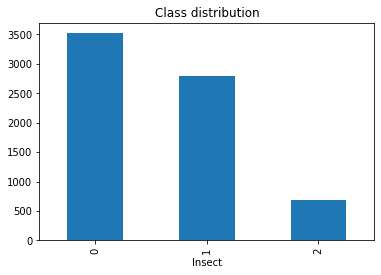

In [97]:
#Ploteamos un grafico de barras para ver la cantidad de resgistros por cada insecto:

df_train.pivot_table(index='Insect', aggfunc='size').plot(kind='bar', title = 'Class distribution')

Vemos en el grafico que tenemos las clases desbalanceadas, muchos registros para los insectos 0 y 1, y pocos para el insecto dos, que es nuestra clase minoritaria.

___

Como en este caso tenemos dos columnas de tiempo en las que una indica la hora y la otra los minutos, vamos a unificar las dos columnas. Para ello vamos a convertir las horas a minutos y luego sumarlo con la columna minutos para asi obtener una sola columna con los minutos totales. Eso nos permite tener una lectura unificada de los datos y poder entrenar mejor el modelo.

In [13]:
#Columna TIME: Convertimos la columna horas a minutos y la sumamos con la columna minutos para obtener los minutos totales:

h_minutos = df_train['Hour']*60
df_train['Time']= h_minutos + df_train['Minutes']
df_train['Time'].head()

0    1346
1     616
2    1302
3    1277
4    1096
Name: Time, dtype: int64

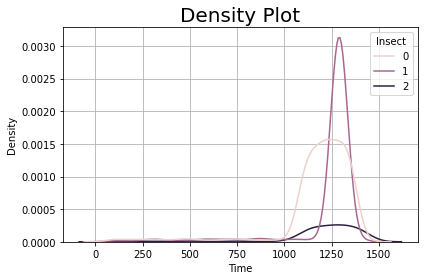

In [118]:
#Ploteamos un Grafico de Densidad para ver la distribucion de los datos de cada insecto respecto al tiempo de registro:
%matplotlib inline
sns.kdeplot(data=df_train, x="Time", hue="Insect")
plt.title("Density Plot",fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

Aqui podemos observar que la distribucion de los datos para cada insecto no esta balanceada ya que tenemos muchos registros de tiempo para para el insecto número 1 y pocos registros para los insectos 0 y 2.
Esto nos da una noción de como trabajar nuestros datos a la hora de procesar nuestros datos y elegir el algoritmo de predicción.

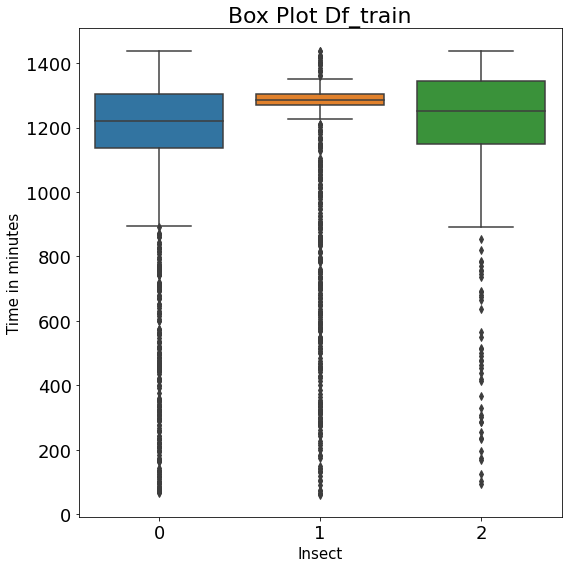

In [117]:
#Corroboramos los outliers o valores atipicos para cada Insecto respecto a la columna tiempo (Time):

fig = plt.figure(figsize=(8,8))

sns.boxplot(x=df_train.Insect, y=df_train.Time) #Grafico Boxplot

plt.title('Box Plot Df_train', fontsize=22)
plt.xlabel("Insect",fontsize=15)
plt.ylabel("Time in minutes", fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



plt.tight_layout()



plt.show()

Como nos muestra claramente el gráfico tenemos muchos valores atipicos que pueden influir en nuestras predicciones. El gráfico de cajas o boxplot nos permite ver de maera fácil estos valores, así como tambien los cuartiles que son los extremos de cada caja y el promedio que sería la línea que divide cada caja.

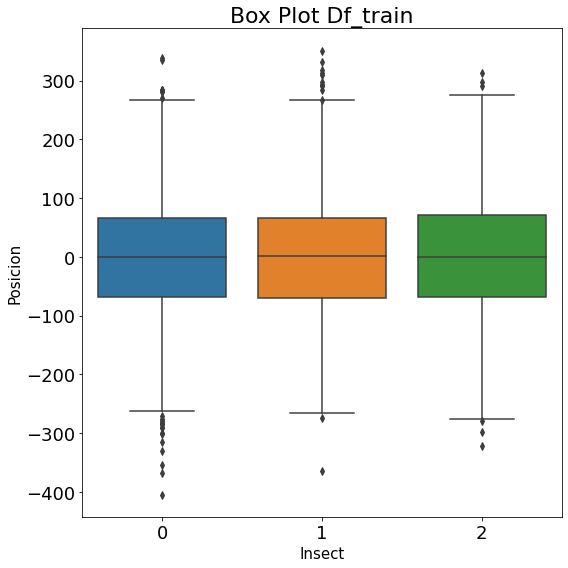

In [116]:
#Veamos los outliers de la columna Sensor Alpha:


fig = plt.figure(figsize=(8,8))

sns.boxplot(x=df_train.Insect, y=df_train.Sensor_alpha) #Grafico Boxplot

plt.title('Box Plot Df_train', fontsize=22)
plt.xlabel("Insect",fontsize=15)
plt.ylabel("Posicion", fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



plt.tight_layout()



plt.show()

Como nos muestra este grafico respecto a los valores de el sensor Alpha, los datos aqui estan mejor distribuidos con menos presencia de valores atipicos en comparacion con la columna Time.

In [17]:
#Veamos el shape de nuestro dataset:
df_train.shape

(7001, 10)

In [18]:
#Correlacion entre nuestras variables:
corr_df_train = df_train.corr()

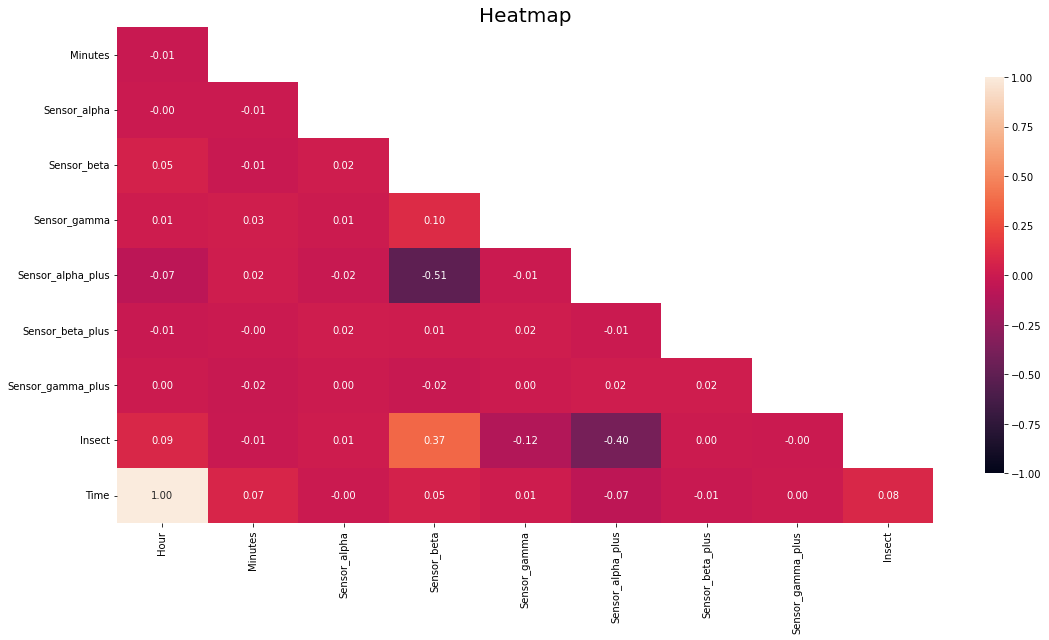

In [19]:
#Lets plot a HeatMap:
np.ones_like(corr_df_train, dtype=bool)
mask = np.triu(np.ones_like(corr_df_train, dtype=bool))
corr_df_train
fig, ax = plt.subplots(figsize=(16,9))# mask

mask = np.triu(np.ones_like(corr_df_train, dtype=bool))# adjust mask and df

mask = mask[1:, :-1]

corr = corr_df_train.iloc[1:,:-1].copy()# plot heatmap

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})# yticks

plt.yticks(rotation=0)
plt.title("Heatmap",  fontsize=20)
plt.tight_layout()
plt.show()

Este grafico de calor muestra la correlación de nuestras variables donde los valores pueden ocilar entre -1 y 1, siendo correlación positiva si es mayor a 0 o correlacion negativa si es menor a 0. La correlacion positiva quiere decir que cuando un valor de nuestra columna aumenta, las columnas con correlacion positiva sobre esta también aumentaran, pero si tienen correlación negativa cuando un valor aumenta el otro disminuye.
En este caso los Sensores Beta, Gamma y Alpha plus tienen una correlación positiva respecto a la variable Insecto en cambio Beta plus, Gamma Plus tienen un valor de 0 lo que quiere decir que no hay correlacion o relacion respecto a la variable insecto. De esta manera podemos saber facilmente que columnas se correlacionan más que otras.

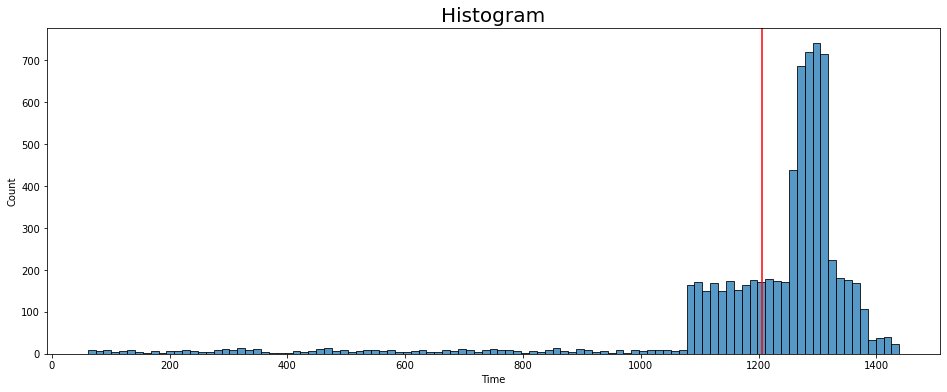

In [20]:
#Ploteamos un historigrama de la columna Time:

time_avg= df_train['Time'].mean()
plt.figure(figsize=(16, 6))
sns.histplot(data=df_train, x='Time')
#Add the mean line.
plt.axvline(x=time_avg, color='red', label='Mean')
plt.title('Histogram', fontsize=20)
plt.xlabel('Time');

En este Historigrama se puede observar la cantidad de registros que hay segun los minutos totales, recordar que nosotros hemos unificado la columna horas y minutos para crear solo una columna de tiempo que así represente todo.
Vemos que el promedio de observaciones es sobre las 20hs o 1200 minutos y la mayor cantidad de registros de insectos coinciden sobre las 21/22 hs de la noche. Mucho mas que sobre las horas del día!

___

 ## Task 2: Modelo Predictivo
 
 Teniendo en claro los datos con los cuales vamos a trabajar, el tipo de dato de mis columnas, la comprobación de valores nulos, correlación de variables, etc. Pasaremos a plantearnos el problema que queremos resolver.
 Estamos ante un problema de clasificación, donde vamos a entrenar nuestro algoritmo con el dataset Train para luego darle como input el dataset Test y así predecir nuestro target (Insecto).
 Utilizaré en este caso el algoritmo Random Forest. Este Modelo funciona muy bien cuando tenemos datos desbalanceados y queremos resolver un problema de clasificación, veamos que resultados obtenemos.

In [80]:
#Dividimos el Dataset en dos variables X e Y, y quitamos las columnas que no nos interesan.

X = df_train.drop(['Insect', 'Hour', 'Minutes'], axis= 1).iloc[:3000]
y = df_train['Insect'].iloc[:3000]

print(X.shape)
print(y.shape)

(3000, 7)
(3000,)


In [112]:
#Dividimos el dataset en dos Train and Test con la libreria de Sk learn para entrenar nuestro modelo y luego evaluarlo:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y, random_state=42)

___
## Random Forest Classifier:

In [83]:
#Asignamos un objeto a nuestro modelo Random Forest Classifier:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [85]:
#Predecimos un resultado con nuestro Dataset de entrenamiento:
y_pred_rf =rf.predict(X_test)

In [114]:
#Dataset de los resultados obtenidos:
results_df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_rf})
results_df

Actual  Predicted
1099       2          0
2348       0          0
2934       1          1
588        0          0
2490       0          0
...      ...        ...
2604       0          0
850        2          2
1253       1          0
1093       1          1
1148       2          2

[900 rows x 2 columns]

In [87]:
#Veamos las metricas de evaluación que obtuvimos:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
# Precision: 
precision_rf = precision_score(y_pred_rf, y_test, average='macro')
print('Precision:', precision_rf)
# Recall: 
recall_rf = recall_score(y_pred_rf, y_test, average='macro')
print('Recall:', recall_rf)
# f1 score
f1_rf = f1_score(y_pred_rf, y_test, average='macro')
print('F1:', f1_rf)

Accuracy: 0.8688888888888889
Precision: 0.7632967979479607
Recall: 0.8685649162598188
F1: 0.7950818600482826


In [88]:
#Generamos la matriz de confusión:
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(cm_rf)

[[407  38   5]
 [ 28 335   1]
 [ 29  17  40]]


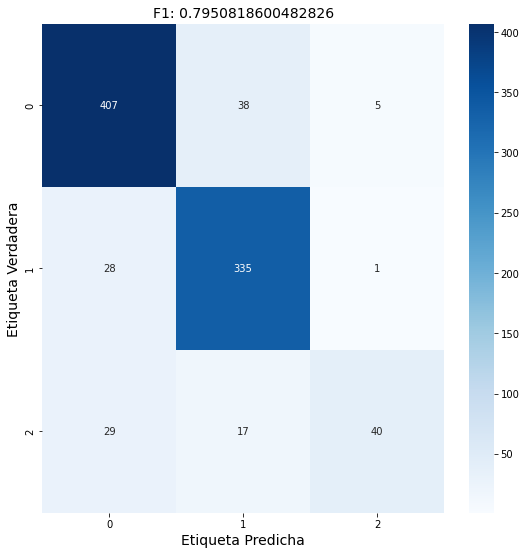

In [115]:
#Ploteamos la matriz de confusión:
plt.figure(figsize=(9,9))


ax = sns.heatmap(cm_rf, annot=True, fmt='', cmap='Blues')

title = 'F1: {0}'.format(f1_rf)
ax.set_title(title, fontsize=14);


ax.set_xlabel('Etiqueta Predicha',fontsize=14)
ax.set_ylabel('Etiqueta Verdadera', fontsize=14);



##Mostramos la matriz.
plt.show()

Aqui podemos ver que la diagonal principal nos muestra los aciertos que tuvo el modelo a la hora de clasificar nuestro target. Mientras que los demas datos corresponden a lo que el algoritmo predijo pero que enrealidad era otro insecto.

___
Cross Validation:

In [32]:
# Computamos 5 cross-validation scores: "Random Forest Validacion Cruzada"
rf_cv = cross_val_score(rf,X,y,cv=5, scoring='f1_macro',  error_score='raise' ) 

#Mostramos los valores:
print(rf_cv)

print("Average 5-Fold CV Score: {}".format(np.mean(rf_cv)))
print('F1 First model:', f1_rf)

[0.84222685 0.8377896  0.7701942  0.84718366 0.8092844 ]
Average 5-Fold CV Score: 0.8213357429704926
F1 First model: 0.7950818600482826


Podemos mejorar nuestra puntuacion del modelo para acercarnos a un f1 de 0.82

___

Grid Search: Creamos un nuevo objeto con nuestro estimador Random Forest para aplicar la técnica Grid Search.

In [35]:
#Modificamos algunos parametros y hacemos las pruebas para averiguar la mejor combinación.:

parametros = { 'n_estimators': (10,20,30),
                'criterion': ('gini', 'entropy'),
                'max_depth': (20,30,40),
                'n_estimators': (100,200,400,600)}

rf_gs = GridSearchCV(rf, parametros,
                    cv=5,
                    scoring='f1_macro',
                    verbose=4)           

rf_gs.fit(X_train, y_train)



print("Average 5-Fold CV Score: {}".format(np.mean(rf_cv)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=gini, max_depth=20, n_estimators=100;, score=0.809 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=20, n_estimators=100;, score=0.819 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=20, n_estimators=100;, score=0.813 total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=20, n_estimators=100;, score=0.806 total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=20, n_estimators=100;, score=0.827 total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=20, n_estimators=200;, score=0.796 total time=   1.0s
[CV 2/5] END criterion=gini, max_depth=20, n_estimators=200;, score=0.838 total time=   1.5s
[CV 3/5] END criterion=gini, max_depth=20, n_estimators=200;, score=0.806 total time=   1.0s
[CV 4/5] END criterion=gini, max_depth=20, n_estimators=200;, score=0.806 total time=   1.2s
[CV 5/5] END criterion=gini, max_depth=20, n_estimators=200;, score=0.831 total time=   1.3s
[CV 1/5]

In [105]:
#Predecimos nuestra X del dataset Train luego del Grid Search:
y_pred_rf_gs = rf_gs.predict(X_test)

In [113]:
#Mostramos el F1 y otras puntuaciones que tuvimos luego del Grid Search(modificacion de parametros):

#Accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf_gs))

# Precision: 
precision_rf_gs = precision_score(y_pred_rf_gs, y_test, average='macro')
print('Precision:', precision_rf)

# Recall: 
recall_rf_gs = recall_score(y_pred_rf_gs, y_test, average='macro')
print('Recall:', recall_rf)

#F1 Macro:
f1_rf_gs = f1_score(y_pred_rf_gs, y_test, average='macro')
rf_best_params = rf_gs.best_params_


print('F1 Macro after Grid Search:', f1_rf_gs)
print('Best Parameters: ', rf_gs.best_params_)

Accuracy: 0.8744444444444445
Precision: 0.7632967979479607
Recall: 0.8685649162598188
F1 Macro after Grid Search: 0.8044376512989474
Best Parameters:  {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 600}


___

#### Una vez que ya tenemos entrenado nuestro modelo y configurado con la mejor combinación de parametros que nos muestra Grid Search, procedemos a pasarle la data de nuestro Test.csv para ver que resultados obtenemos:

In [44]:
#Importamos el Test DataSet:
df_test = pd.read_csv('test_x.csv', index_col=0)
print(df_test.head())
print(df_test.shape)

      Hour  Minutes  Sensor_alpha  Sensor_beta  Sensor_gamma  \
7000    21       31    -72.083585   -11.434977    -52.961743   
7001    21        3   -193.619980    40.137081     85.419244   
7002    22       31     42.578382   -51.613402    125.055611   
7003    21       25    -64.150951   287.306752    -70.965473   
7004    18       11    193.750787   -61.989533   -110.347066   

      Sensor_alpha_plus  Sensor_beta_plus  Sensor_gamma_plus  
7000         -72.696385        145.299227        -143.856243  
7001         -26.266801       -125.391237          80.904973  
7002         182.136746         -9.726951        -114.913402  
7003          13.789738         38.187260         137.761691  
7004         -16.864786        148.541916         232.424616  
(3000, 8)


In [45]:
#Convertimos la columna Horas y minutos a una sola columna de Tiempo con la unidad establecida en minutos:
time_column = df_test['Hour']*60
df_test['Time']= time_column + df_test['Minutes']
df_test['Time'].head()

7000    1291
7001    1263
7002    1351
7003    1285
7004    1091
Name: Time, dtype: int64

In [46]:
#Asignamos un nombre a nuestro DataSet Test:
Test = df_test.drop(['Hour', 'Minutes'], axis= 1)
Test.shape

(3000, 7)

In [108]:
#Predecimos el target de nuestro dataset Test con el objeto Random Forest Classifier Grid Search:

results = rf_gs.predict(Test)

In [109]:
#Creamos el dataset con los resultados:
results=pd.DataFrame({'Predicted Insect':results})
results

Predicted Insect
0                    1
1                    1
2                    0
3                    2
4                    0
...                ...
2995                 1
2996                 0
2997                 1
2998                 0
2999                 2

[3000 rows x 1 columns]

In [111]:
#Guardamos nuestro archivo results con los resultados que obtuvimos de nuestro dataset Test:

results.to_csv('results.csv', header=True, index=True)


___


# Conclusión: 
## Durante el desarrollo de este modelo se procedió a unificar la columna de horas y minutos a una misma unidad (minutos), y así poder entrenarlo de manera correcta. Primero creamos el modelo sin modificarle los parametros y utilizando solo el 70% de ella para entrenarlo obtuvimos un F1 score de 0,795 (promedio entre Precision y Recall), el cual es aceptable pero se podía mejorar. Hicimos una Validación Cruzada(Cross Validation) para evaluar los resultados obtenidos y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. Una vez hecha la validación cruzada modificamos de los parametros con la técnica Grid Search, y nuestro modelo mejoró, logramos optimizarlo y obtuvimos un F1 de 0,804 cuando pusimos como input nuestro TEST dataset lo cual es bastante aceptable pero se deberia seguir mejorando y modificando parametros para que el algoritmo clasifique y predecir mejor cuando se le pasan datos nuevos con los cuales no fue entrenado.





___

Documentación:
- Random Forest Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Grid Search Technique: https://scikit-learn.org/stable/modules/grid_search.html
- Cross Validation: https://scikit-learn.org/stable/modules/cross_validation.html
- Pandas Profiling: https://pypi.org/project/pandas-profiling/